# Part 3: Building an NDT for Next-Generation WLANs with Graph Neural Networks

This notebook will process the provided dataset to create a NDT using techniques such as Graph Neural Networks (GNNs). The dataset was created for the 2020 edition of the [ITU AI for 5G Challenge](https://challenge.aiforgood.itu.int/) in the wireless throughput prediction statement. The dataset was created using [Komondor](https://github.com/wn-upf/Komondor), a simulator for next-generation, high-density WLANs which includes novel functionalities such as channel bonding and spatial reuse. The generated data includes simulated data from IEEE 802.11 WLAN deployments applying Dynamic Channel Bonding, using different random parameters, including channel allocation, location of nodes, and number of STAs per AP. The original dataset can be found in [here](https://doi.org/10.5281/zenodo.4106127). Then, the dataset was parsed using the file ```parse_original_dataset.py``` and then uploaded to Google Drive.  We include a fixed 80/20 split, where, from the original dataset (600 deployments in total), 80% of the deployments were used for training and while the remaining 20% was used for validation.

To process the dataset for GNNs, we heavily rely on PyTorch Geometric, a library built upon PyTorch to easily write and train GNN models for a wide range of applications related to structured data.

Packages such as jupyter, pandas, numpy and scikit-learn are already installed in a instance of Google Colab. Also PyTorch is already included, so there is no need to install them. However, you need to install the PyTorch Geometric version that satisfies the PyTorch version.

Run first the following commands to find out which PyTorch and CUDA version you are using.
```
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')


TORCH_version = torch.__version__
print(f"you are using pytorch and cuda {TORCH_version}")
TORCH = format_pytorch_version(TORCH_version)
print(f"you are using pytorch {TORCH}")

CUDA_version = torch.version.cuda
print(f"you are using cuda {CUDA_version}")
CUDA = format_cuda_version(CUDA_version)
```

Then you can run in a cell the corresponding pip command to install pytorch geometric.

```
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
```

If the notebook is run through Google Colab, then clone the repository and upload the root folder (e.g., gnn-tutorial) to your personal Drive. Then, mount your Drive, so you can import the dataset module using:

```
from google.colab import drive
drive.mount('/content/gdrive')
```
Then, you can check the content mounted at ```/content/gdrive``` using:

```
! ls /content/gdrive/My\ Drive/
```
We'll need to update our path to import from Drive using:

```
import sys
sys.path.append('/content/gdrive/My Drive/<path to dataset_gnn.py>')
```

Remember to replace the path where you can locate the ```dataset_gnn.py```. Now we can import the library and use the function with:

```
import dataset_gnn
```

Assuming that you meet all the requirements from above, we start by importing the necessary libraries. Remember to use ```import dataset_gnn``` instead of ```from auxiliaries import dataset_gnn``` and ```from evaluation import scores``` instead of ```from auxiliaries.evaluation import scores``` if this notebook is run in Google Colab.

In [1]:
# Standard python libraries.
import os
from pathlib import Path
import shutil
import math
import random

# General data science libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Deep learning libraries.
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import MetaLayer
from torch_scatter import scatter_mean

# now we can import all the functions from the auxiliaries' folder, depending on where you are executing this notebook, you might use import dataset_gnn instead of the line below
from auxiliaries import dataset_gnn
# if executed in google colab, replace the line below with from evaluation import scores, access_point_throughputs
from auxiliaries.evaluation import scores, access_point_throughputs

/Users/paola/opt/anaconda3/envs/gnn-tutorial/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we proceed to download, extract, and accommodate the dataset in a proper format to be used by the GNN model we create later.

In [2]:
########################################################################################################################
# Dataset.
########################################################################################################################

root = './datasets/NDTDataset/gnn/'

# Load training dataset.
dataset_train = dataset_gnn.NDTDataset(root, split='train')
dataset_valid = dataset_gnn.NDTDataset(root, split='valid')
dataset_test = dataset_gnn.NDTDataset(root, split='test')

Extracting datasets/NDTDataset/gnn/raw/uc
Processing...


Processing train split.


/Users/paola/coding_projects/gnn-tutorial/auxiliaries/dataset_gnn.py:358: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756028548/work/torch/csrc/utils/tensor_new.cpp:210.)
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)


Processing valid split.
Processing test split.


Done!


The dataset is comprised from two kind of files, one is the "input_node_files.csv" which contains the deployment information and their respective configuration (e.g., channels bonded, node location, WLAN code). This information is given to Komondor which simulates 100 seconds of transmission and the output from the simulator is given in the "output_simulator" files (e.g., airtime, obtained throughput, interference and measured SINR and RSSI). We use content from both files to compose the graph's features. The features taken from the original dataset are the following.

1. 'node_type': the considered node is an AP (0) or a STA (1). --> Node Feature
2. 'node_x_coordinate': the x coordinate of the node spatial position. --> Node Feature
3. 'node_y_coordinate': the y coordinate of the node spatial position. --> Node Feature
4. 'node_primary_channel': the primary channel of the AP. --> Node Feature
5. 'min_channel_allowed': the minimum channel allowed to perform channel bonding. --> Node Feature
6. 'max_channel_allowed': the maximum channel allowed to perform channel bonding. --> Node Feature
7. 'sinr': the obtained Signal plus Interference to Noise Ratio (SINR) between the AP and the STA. The feature is 0 for AP devices. --> Edge (AP-STA) Feature
8. 'mean_airtime': the mean percentage of airtime given by the used channel. The feature is 0 for STAs.  --> Node Feature
9. 'interference': the mean measured interferences between APs. --> Edge (AP-AP) Feature
10. 'rssi': the obtained Received Signal Strength Indicator (RSSI) between the AP and the STA. --> Edge (AP-STA) Feature
11. 'distance_to_ap': the euclidean distance between AP and STA. --> Edge (AP-STA) Feature
12. 'bandwidth': the total bandwidth used. We consider 20 MHz per used channel. --> Edge (AP-STA) Feature

There are two kind of nodes, APs and STAs, which we differentiate through the 'node_type' feature. Similarly, there are two kind of edges, an edge between APs (i.e., AP-AP edge) and an edge between AP and associated STAs (i.e., AP-STA edge). We assign features that are relevant for the AP-STA relationship (e.g., RSSI) but since this feature has no meaning in the AP-AP edges, the feature in those edges is set to zero. During its processing we encode the channel configuration ('node_primary_channel', 'min_channel_allowed', 'max_channel_allowed') using one hot encoder, which extends it into a vector of six positions. Let's load the dataset in memory.

In [3]:
# Select the batch size.
BATCH_SIZE = 32

# Dataset loaders.
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE)         # we are loading 32 graphs each time
valid_loader = DataLoader(dataset_valid, batch_size=1)                  # we are validating one graph at a time
test_loader = DataLoader(dataset_test, batch_size=1)                    # we are evaluating one graph at a time

We can observe our dataset.

In [4]:
print(f'Train samples (GRAPHS): ')
print(f'Input: {dataset_train}')
print(f' ')
print(f'Validation samples (GRAPHS): ')
print(f'Input: {dataset_valid}')
print(f' ')
print(f'Info inside one sample (ONE GRAPH): ')
print(f'Input shape: {dataset_train[0].x.shape}')
print(f'Node Features size: {dataset_train[0].num_node_features}')
print(f'Target shape: {dataset_train[0].y.shape}')
print(f'Edge Features shape: {dataset_train[0].edge_attr.shape}')
print(f'Edge Features size: {dataset_train[0].num_edge_features}')

Train samples (GRAPHS): 
Input: NDTDataset(480)
 
Validation samples (GRAPHS): 
Input: NDTDataset(120)
 
Info inside one sample (ONE GRAPH): 
Input shape: torch.Size([170, 10])
Node Features size: 10
Target shape: torch.Size([170])
Edge Features shape: torch.Size([580, 5])
Edge Features size: 5


We are now ready to start to build our GNN model. Remember that we are exploiting the properties of the real deployment. Therefore, we can have features on the edges and on the nodes of the graph representation. Consequently, we can leverage from a GNN model that exploits such properties and computes the features for the edges and for the nodes in two separate models (i.e., 'EdgeModel' and 'NodeModel'). So far, the only GNN layer implemented in PyTorch Geometric that is able to do that, is the so called [MetaLayer](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/meta.html#MetaLayer). Thus, we built a GNN model using two MetaLayers having the same configuration. The input to those layers matches the input of the data. All layer use ReLU as activation function. The last layer has dimension 1, since we are trying to predict only one value (i.e., throughput). The architecture of the model was found following a trial and error strategy.

In [5]:
########################################################################################################################
# Model's Architecture
########################################################################################################################

class EdgeModel(torch.nn.Module):
    def __init__(self, n_node_features, n_edge_features, hiddens, n_targets):
        super().__init__()
        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * n_node_features + n_edge_features, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, n_targets),
        )

    def forward(self, src, dest, edge_attr, u=None, batch=None):
        out = torch.cat([src, dest, edge_attr], 1)
        out = self.edge_mlp(out)
        return out


class NodeModel(torch.nn.Module):
    def __init__(self, n_node_features, hiddens, n_targets):
        super(NodeModel, self).__init__()
        self.node_mlp_1 = torch.nn.Sequential(
            torch.nn.Linear(n_node_features + hiddens, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, hiddens),
        )
        self.node_mlp_2 = torch.nn.Sequential(
            torch.nn.Linear(n_node_features + hiddens, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, n_targets),
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([x[col], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, row, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        out = self.node_mlp_2(out)
        return out


class MetaNet(torch.nn.Module):
    def __init__(self, n_node_features, n_edge_features, num_hidden):
        super(MetaNet, self).__init__()

        # Input Layer
        self.input = MetaLayer(
            edge_model=EdgeModel(
                n_node_features=n_node_features, n_edge_features=n_edge_features,
                hiddens=num_hidden, n_targets=num_hidden),
            node_model=NodeModel(n_node_features=n_node_features, hiddens=num_hidden, n_targets=num_hidden)
            )

        # Output Layer
        self.output = MetaLayer(
            edge_model=EdgeModel(
                n_node_features=num_hidden, n_edge_features=num_hidden,
                hiddens=num_hidden, n_targets=num_hidden),
            node_model=NodeModel(n_node_features=num_hidden, hiddens=num_hidden, n_targets=1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, y = data.x, data.edge_index, data.edge_attr, data.y

        x, edge_attr, _ = self.input(x, edge_index, edge_attr)
        x = F.relu(x)
        x, edge_attr, _ = self.output(x, edge_index, edge_attr)

        return x

Then, we can set up the configuration we want. For example, we can select the number of hidden units for the MetaLayers, the number of training epochs, the log interval and the directory where we want to save our best model. As suggested by PyTorch, we select the computing device that better suit the computations.

In [6]:
# Configuration

## Network Configuration
num_node_features = dataset_train[0].x.shape[1]
num_edge_features = dataset_train[0].edge_attr.shape[1]
num_hidden = 128


## Training Configuration
NUM_EPOCHS = 10
LOG_INTERVAL = 1
CHECKPOINT_INTERVAL = 1
CHECKPOINT_DIR = "checkpoints/gnn"
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 32

Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)

# Compute device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


# Create model.
model = MetaNet(num_node_features, num_edge_features, num_hidden).to(device)
# Configure optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


Using device: cpu


Unfortunately, PyTorch does not have an automatic method for training and evaluating models such as Tensorflow (i.e., 'model.fit'). Therefore, we need to implement the training loop and the evaluation loop.

In [7]:
#######################################################################################################################
# Training utilities.
########################################################################################################################

# train step
def train(dataset):
    # Monitor training.
    losses = []

    # Put model in training mode!
    model.train()
    for batch in dataset:
        # Training step.
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = torch.sqrt(F.mse_loss(out.squeeze()[batch.y_mask], batch.y[batch.y_mask]))
        loss.backward()
        optimizer.step()
        # Monitoring
        losses.append(loss.item())

    # Return training metrics.
    return losses

# evaluation step
def evaluate(dataset):
    # Monitor evaluation.
    losses = []
    rmse = []

    # Validation (1)
    model.eval()
    for batch in dataset:
        batch = batch.to(device)

        # Calculate validation losses.
        out = model(batch)
        loss = torch.sqrt(F.mse_loss(out.squeeze()[batch.y_mask], batch.y[batch.y_mask]))

        rmse_batch = scores(batch, out)

        # Metric logging.
        losses.append(loss.item())
        rmse.append(rmse_batch.item())

    return losses, rmse

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    Taken from https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)



Now we are ready to train our model. We save the model every checkpoint interval.

In [8]:
########################################################################################################################
# Training loop.
########################################################################################################################

best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model')
Path(best_model_path).mkdir(parents=True, exist_ok=True)

# Metrics recorder per epoch.
train_losses = []

valid_losses = []
valid_losses_corrected = []

# Initialize tracker for minimum validation loss
valid_loss_min = valid_loss_min_input = np.Inf

# Training loop.
model.train()
for epoch in range(NUM_EPOCHS):
    # Train.
    train_epoch_losses = train(train_loader)
    valid_epoch_losses, valid_epoch_losses_corrected = evaluate(valid_loader)

    # Log training metrics.
    train_avg_loss = np.mean(train_epoch_losses)
    train_losses.append(train_avg_loss)

    # Log validation metrics.
    valid_avg_loss = np.mean(valid_epoch_losses)
    valid_losses.append(valid_avg_loss)

    valid_avg_loss_corrected = np.mean(valid_epoch_losses_corrected)
    valid_losses_corrected.append(valid_avg_loss_corrected)

    # Print metrics
    if epoch % LOG_INTERVAL == 0:
        print(f"epoch={epoch}, train_loss={train_avg_loss}, valid_loss={valid_avg_loss}, valid_loss*={valid_avg_loss_corrected}")

    if epoch % CHECKPOINT_INTERVAL == 0:
        # compose checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_avg_loss,
        }

        checkpoint_fn = os.path.join(CHECKPOINT_DIR, f'checkpoint-{epoch}.tar')
        save_ckp(checkpoint, False, checkpoint_fn, checkpoint_fn)


    if valid_avg_loss_corrected <= valid_loss_min:
        # save checkpoint as best model
        best_model_fn = os.path.join(best_model_path, f'best-model.tar')
        save_ckp(checkpoint, True, checkpoint_fn, best_model_fn)
        valid_loss_min = valid_avg_loss_corrected


epoch=0, train_loss=10.654210567474365, valid_loss=8.381394418080648, valid_loss*=22.306682085990907
epoch=1, train_loss=7.913446108500163, valid_loss=7.758117789030075, valid_loss*=20.16065516869227
epoch=2, train_loss=7.6906197706858315, valid_loss=7.136931588252385, valid_loss*=18.27455825805664
epoch=3, train_loss=7.263824335734049, valid_loss=6.653706687688827, valid_loss*=17.02637677192688
epoch=4, train_loss=6.245344384511312, valid_loss=5.953273763259252, valid_loss*=15.170136411984762
epoch=5, train_loss=5.666444762547811, valid_loss=6.310026067495346, valid_loss*=18.282210437456765
epoch=6, train_loss=7.575535217920939, valid_loss=6.61850667198499, valid_loss*=17.77659427324931
epoch=7, train_loss=5.885825649897257, valid_loss=7.481217183669409, valid_loss*=23.35353463490804
epoch=8, train_loss=8.70046656926473, valid_loss=8.494736138979594, valid_loss*=25.31398758093516
epoch=9, train_loss=7.929673385620117, valid_loss=9.186150523026784, valid_loss*=29.301857431729633


We can now see how the performance during training was.

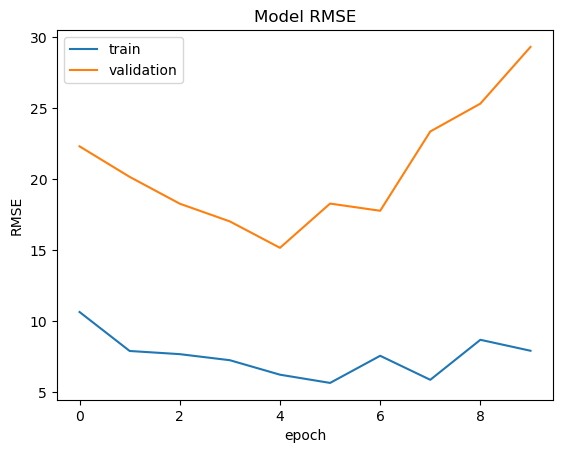

In [9]:
########################################################################################################################
# Training history.
########################################################################################################################

# summarize history for RMSE
plt.plot(train_losses)
plt.plot(valid_losses_corrected)
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Remember that only ten epochs is too few to determine if the model is performing good or not. Thus, we need to train at least for 100 or even 1000 epochs to see if the model can lower the validation loss. Similarly to the other notebook, after the model is trained we can generate some predictions. As imagined, the throughput of the STAs was approximated by the model, but we did not take into account the throughput of the APs (the loss is only calculated for the STAs with ```batch.y_mask```). We calculate the AP's throughput by summing the throughput of its associated STAs.


In [10]:
# Load Model.
best_model_location = os.path.join(best_model_path, 'best-model.tar')
checkpoint = torch.load(best_model_location, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# and where the prediction are going to be saved
predictions_location = os.path.join("predictions", "gnn")

# Make predictions

# Monitor evaluation.
losses = []
rmse = []

# Validation (1)
model.eval()
for batch in test_loader:
    batch = batch.to(device)

    # Calculate validation losses over all devices.
    with torch.no_grad():
        out = model(batch)

    preds_ap_sta = out.detach().numpy()

    # Calculate validation losses over stations only
    with torch.no_grad():
        out = model(batch)

    # Extract station predictions and corresponding access point labels.
    station_predictions = out[batch.y_mask]
    station_labels = batch.node_ap[batch.y_mask]

    # Aggregate (sum) station predictions per access point and update model predictions.
    ap_predictions = access_point_throughputs(station_predictions, station_labels).to(device)
    out[~batch.y_mask] = ap_predictions

    preds_sta = out.detach().numpy()

    deployment = batch.deployment.detach().numpy()[0]
    scenario = batch.scenario[0]

    predict_loc = os.path.join(predictions_location, scenario)
    os.makedirs(predict_loc, exist_ok=True)
    predict_fn = 'throughput_{}.csv'.format(deployment)
    predict_loc = os.path.join(predict_loc, predict_fn)
    df = pd.DataFrame(data=preds_sta, columns=['thr_pred'])
    df.to_csv(predict_loc, index=False)

Now that we have the predictions, we can take the Root Mean Square Error to evaluate the accuracy of the model. We will do it in only one deployment, but you can easily replicate for all the deployment.

In [11]:
# Select the scenario and the deployment to be evaluated.
possible_scenarios = ['test_sce1', 'test_sce2', 'test_sce3', 'test_sce4']
random_scenario = random.choice(possible_scenarios)
random_deployment = random.choice(range(50))        # there are 50 deployments per test scenario.
dpl_true = random_deployment + 1                    # the original files are from 1-50 while the predictions are from 0-49

print(f"Selected random scenario: {random_scenario}")
print(f"Selected random deployment: {random_deployment}")

Selected random scenario: test_sce1
Selected random deployment: 28


In [12]:
# load the real values
true_thr_location = os.path.join("datasets", "NDTDataset", "gnn", "raw", "test", "output_simulator", random_scenario + "_output", "throughput_"+ str(dpl_true) + ".csv")
true_thr = pd.read_csv(true_thr_location, header=None)
true_thr = true_thr.T[0].to_list()

# load predicted values
predicted_thr_location = os.path.join("predictions", "gnn", random_scenario, "throughput_"+ str(random_deployment) + ".csv")
predicted_thr = pd.read_csv(predicted_thr_location)
predicted_thr = predicted_thr["thr_pred"].to_list()

The Root Mean Square Error (RMSE) is a risk function that helps us determine the average squared difference between the predicted and the actual value of a feature or variable. Usually, a RMSE score of less than 180 is considered a good score for a moderately or well working algorithm. In case, the RMSE value exceeds 180, we need to perform feature selection and hyper parameter tuning on the parameters of the model.

In [13]:
MSE = np.square(np.subtract(true_thr,predicted_thr)).mean()
RMSE = math.sqrt(MSE)
print(f"Root Mean Square Error: {RMSE}")

Root Mean Square Error: 27.723271209573802
